**Řešíme 2D úlohu konekce:**
$$\begin{align*}
    \frac{\partial u}{\partial t} + \beta \frac{\partial u}{\partial x} &= 0, \quad x \in [0, 2\pi],\,t\in[0, 1] \\
    u(x, 0) &= \sin(x) + \cos(x) \\
    u(0, t) &= u(2\pi, t),
\end{align*}$$
kde $\beta > 0$ je koeficient konvekce. Analytické řešení je
$$\begin{equation*}
    u(x, t) = \sin(x - \beta t) + \cos(x - \beta t).
\end{equation*}$$
Níže natrénujeme model řešící tuto úlohu, a poté jej porovnáme se správným řešením úlohy.
První trénování proběhne bez použití fourier features, druhé s jejich použitím.

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# Zakladni importy
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import sys

In [10]:
# Import vlastnich modulu
sys.path.append("..")
import src.data.cube_domain as cb
import src.models.mlp_model as mm
from src import train
from src import calculus as calc
from src import utils

In [11]:
# Volba spravneho device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
# Definice ztratove funkce

BETA = 30 # BETA -- konstanta konvekce

# BETA neni argument funkce, protoze kazdy trenovaci algoritmus ocekava, ze 
# jako argument jen a pouze model a domena.
def loss_fn(model: torch.nn.Module, domain: cb.CubeDomain) -> torch.Tensor:
    _, u_x, u_t = calc.compute_derivatives_2d(model, domain.interior)
    pde_loss = torch.mean((u_t + BETA * u_x)**2)

    u_bottom = model(domain.sides[1][0])
    left_loss = torch.mean((u_bottom - torch.sin(domain.sides[1][0][:, 0:1]) 
                            - torch.cos(domain.sides[1][0][:, 0:1]))**2)

    u_left = model(domain.sides[0][0])
    u_right = model(domain.sides[0][1])
    top_bot_loss = torch.mean((u_left - u_right)**2)

    return [pde_loss, left_loss, top_bot_loss]

def exact_solution(x: torch.Tensor) -> torch.Tensor:
    return torch.sin(x[:, 0:1] - BETA * x[:, 1:2]) + torch.cos(x[:, 0:1] - BETA * x[:, 1:2])

def l2_loss(model: torch.nn.Module, domain: cb.CubeDomain) -> torch.Tensor:
    return calc.l2_dist_2d(model, exact_solution, domain.ctx.u_bounds, domain.ctx.l_bounds, device)

In [13]:
# Definice modelu, domeny problemu a optimalizatoru
# prostor x je prvni (nulta) promenna,
# cas t je druha (prvni) promenna
domain_ctx = cb.CubeContext(
    dim=2,
    l_bounds=[0, 0],
    u_bounds=[2*np.pi, 1],
    N_int=10_000,
    N_sides=[(500, 500), (500, 500)],
    device=device,
    mirror_left_right=[True, False]
)

model_ctx = mm.ModelContext(
    input_dim=2,
    output_dim=1,
    layer=[64, 64, 128],
    u_bounds=domain_ctx.u_bounds,
    l_bounds=domain_ctx.l_bounds,
    fourier_features=False
)

model = mm.MLPModel(model_ctx).to(device)
domain = cb.CubeDomain(domain_ctx)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
scheduler = ReduceLROnPlateau(optimizer=optimizer, factor=0.5, patience=300)

In [14]:
# Trenujeme algoritmus a ukladame hodnoty ztraty
train_ctx = train.TrainingContext(
    model=model,
    optimizer=optimizer,
    domain=domain,
    loss_fn=loss_fn,
    epochs=10_000,
    monitor_lr=True,
    scheduler=scheduler,
    resample_freq=100
)

total_loss_values, component_loss_values = train.train_switch_to_lbfgs(train_ctx, epochs_with_lbfgs=1000, lbfgs_lr=0.08)

Loss at epoch 1 is: 1.082139015197754. Current learing rate: 0.0005 
Loss at epoch 100 is: 0.9340800046920776. Current learing rate: 0.0005 
Loss at epoch 200 is: 0.786212682723999. Current learing rate: 0.0005 
Loss at epoch 300 is: 0.23485437035560608. Current learing rate: 0.0005 
Loss at epoch 400 is: 0.1459791362285614. Current learing rate: 0.0005 
Loss at epoch 500 is: 0.11201928555965424. Current learing rate: 0.0005 
Loss at epoch 600 is: 0.10063274949789047. Current learing rate: 0.0005 
Loss at epoch 700 is: 0.09540407359600067. Current learing rate: 0.0005 
Loss at epoch 800 is: 0.08357292413711548. Current learing rate: 0.0005 
Loss at epoch 900 is: 0.08267658948898315. Current learing rate: 0.0005 
Loss at epoch 1000 is: 0.07967864722013474. Current learing rate: 0.0005 
Loss at epoch 1100 is: 0.08148809522390366. Current learing rate: 0.0005 
Loss at epoch 1200 is: 0.08270661532878876. Current learing rate: 0.0005 
Loss at epoch 1300 is: 0.06132885068655014. Current lear

In [15]:
# A nyni s fourier features
model_ctx.fourier_features = True
model_ctx.fourier_frequencies = 200
model_ctx.fourier_scale = 2.0 # arbitrarni hodnoty

model_ff = mm.MLPModel(model_ctx).to(device)
optimizer_ff = torch.optim.AdamW(model_ff.parameters(), lr=0.0001, weight_decay=2e-2)
scheduler_ff = ReduceLROnPlateau(optimizer=optimizer_ff, factor=0.75, patience=200)

In [16]:
# Trenujeme algoritmus a ukladame hodnoty ztraty
train_ctx.model = model_ff
train_ctx.optimizer = optimizer_ff
train_ctx.scheduler = None
train_ctx.epochs = 10_000

total_loss_values_ff, component_loss_values_ff = train.train_switch_to_lbfgs(train_ctx, epochs_with_lbfgs=1000, lbfgs_lr=0.1)

Loss at epoch 1 is: 29.02289581298828. Current learing rate: 0.0001 
Loss at epoch 100 is: 1.0940483808517456. Current learing rate: 0.0001 
Loss at epoch 200 is: 0.9746747016906738. Current learing rate: 0.0001 
Loss at epoch 300 is: 0.973953366279602. Current learing rate: 0.0001 
Loss at epoch 400 is: 0.9818018674850464. Current learing rate: 0.0001 
Loss at epoch 500 is: 0.9161720871925354. Current learing rate: 0.0001 
Loss at epoch 600 is: 0.886633574962616. Current learing rate: 0.0001 
Loss at epoch 700 is: 0.874984622001648. Current learing rate: 0.0001 
Loss at epoch 800 is: 0.777364194393158. Current learing rate: 0.0001 
Loss at epoch 900 is: 0.627352237701416. Current learing rate: 0.0001 
Loss at epoch 1000 is: 0.442618191242218. Current learing rate: 0.0001 
Loss at epoch 1100 is: 0.29418084025382996. Current learing rate: 0.0001 
Loss at epoch 1200 is: 0.2055768519639969. Current learing rate: 0.0001 
Loss at epoch 1300 is: 0.13221338391304016. Current learing rate: 0.0

/home/berva/Projects/PINNs/Introduction/notebooks/../src/utils.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_x_labels)


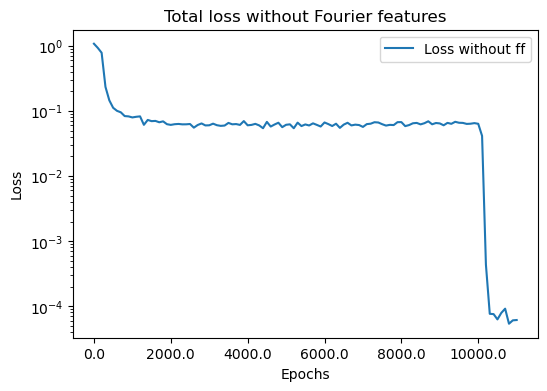

/home/berva/Projects/PINNs/Introduction/notebooks/../src/utils.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_x_labels)


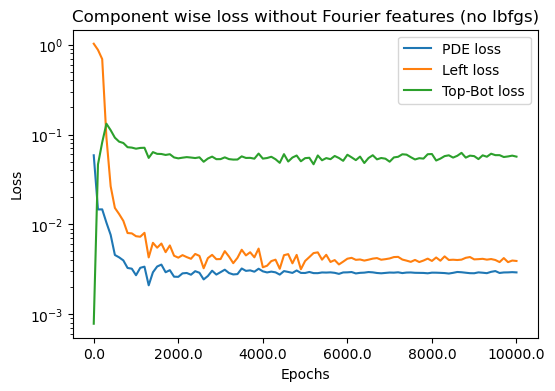

In [23]:
# Vykresleni ztraty
plot_ctx = utils.PlotContext(
    l_bounds = [0, 0],
    u_bounds=[2*np.pi, 1],
    patches=[],
    device=device,
    vmin=-1.3,
    vmax=1.3,
    N=100,
    save_img=False,
    x_label='Epochs',
    y_label='Loss',
)

plot_ctx.title = 'Total loss without Fourier features'
utils.plot_loss_values({"Loss without ff": total_loss_values}, plot_ctx)
plot_ctx.title = 'Component wise loss without Fourier features (no lbfgs)'
utils.plot_loss_values({"PDE loss": component_loss_values[0],
                        "Left loss": component_loss_values[1],
                        "Top-Bot loss": component_loss_values[2]}, plot_ctx)

/home/berva/Projects/PINNs/Introduction/notebooks/../src/utils.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_x_labels)


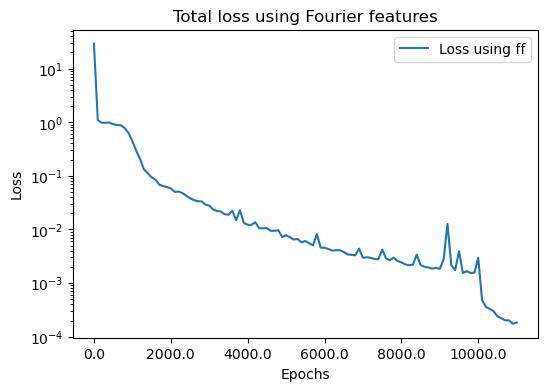

/home/berva/Projects/PINNs/Introduction/notebooks/../src/utils.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_x_labels)


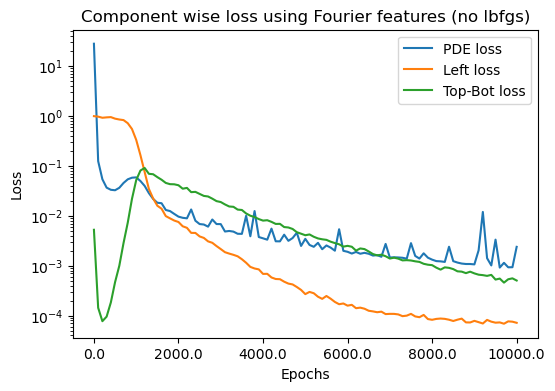

In [24]:
plot_ctx.title = 'Total loss using Fourier features'
utils.plot_loss_values({"Loss using ff": total_loss_values_ff}, plot_ctx)
plot_ctx.title = 'Component wise loss using Fourier features (no lbfgs)'
utils.plot_loss_values({"PDE loss": component_loss_values_ff[0],
                        "Left loss": component_loss_values_ff[1],
                        "Top-Bot loss": component_loss_values_ff[2]}, plot_ctx)

/home/berva/anaconda3/envs/pytorch/lib/python3.12/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647329220/work/aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


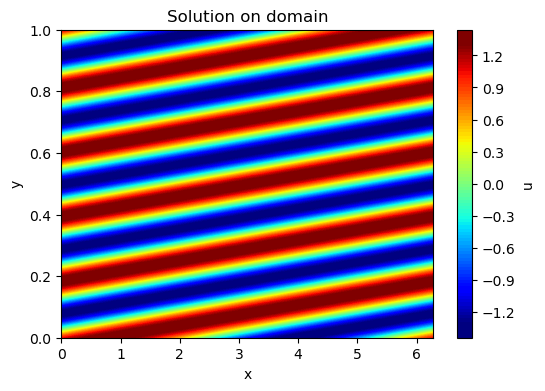

In [19]:
# Vykresleni priblizneho reseni (minus interpolace)
plot_ctx.title = 'Solution on domain'
plot_ctx.x_label = 'x'
plot_ctx.y_label = 'y'

utils.plot_function_on_2d_cube(model, plot_ctx)

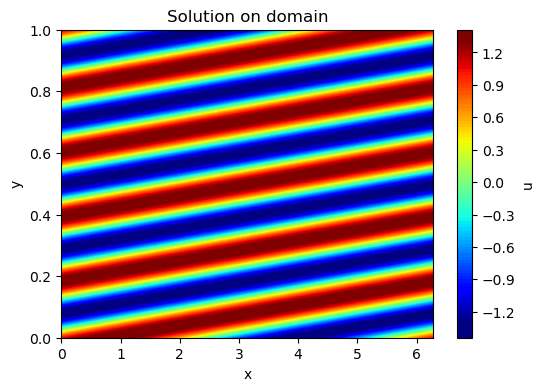

In [20]:
torch.cuda.empty_cache()

utils.plot_function_on_2d_cube(model_ff, plot_ctx)

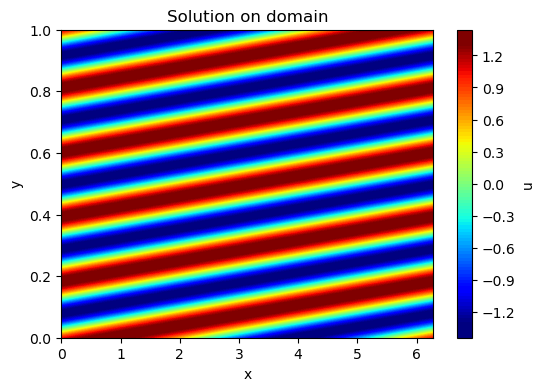

In [21]:
# Vykresleni skutecneho reseni (minus interpolace)
BETA = 30
utils.plot_function_on_2d_cube(exact_solution, plot_ctx)

In [22]:
# a na zaver porovnani pomoci L2 normy
norm = calc.L2_norm(model, exact_solution, 2, domain_ctx.u_bounds, domain_ctx.l_bounds, device)

print(f"L2 chyba bez ff je {norm}")

norm_ff = calc.L2_norm(model_ff, exact_solution, 2, domain_ctx.u_bounds, domain_ctx.l_bounds, device)

print(f"L2 chyba s ff je {norm_ff}")

L2 chyba bez ff je 0.03568066284060478
L2 chyba s ff je 0.0665409043431282
